In [5]:
# Imports
import base64
import pandas as pd
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Load the data with Pandas
train_df = pd.read_csv("data/train.csv", usecols=['text', 'author'])
test_df = pd.read_csv("data/test.csv", usecols=['text'])

In [ ]:
# What is the size of the training dataframe?
# It shows that the training data has 19579 rows of our text and author columns
print(train_df.shape)

In [ ]:
# Inspect a few examples
train_df.head()

In [ ]:
# What is the size of the test dataframe?
print(test_df.shape)

In [ ]:
# We can see that the test data does not have author labels. That's our goal; to figure out the authors
test_df.head()

In [11]:
# Seaborn and matplotlib make it very easy to produce a graph of the number of sentences there are
# in the training set for each author
plt.figure(figsize=(12,6))
sns.set(style="ticks")
sns.set_palette(palette="pastel")
sns.countplot(x="author", data=train_df)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Author', fontsize=14)
plt.title("Author Frequency distribution", fontsize=18)
plt.show()

There are approximately 2000 more sentences by Poe than by Lovecraft or Shelley, or approximately 1/3rd more, which is somewhat unbalanced.

(array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([   0,    1,    2, ..., 4660, 4661, 4662]),
 <a list of 1 Patch objects>)

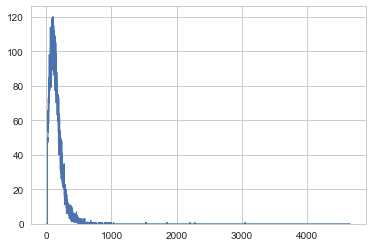

In [14]:
# Let's have a look at the distribution of line lengths
sns.set()
plt.style.use('seaborn-whitegrid')
lengths = [len(line) for line in train_df['text']]
plt.hist(lengths, bins=np.arange(max(lengths)), histtype='step', linewidth=1)

That long tail is not suprising, although there seem to be a few very very long lines!

In [10]:
# Let's have a look a the longest
print(max(lengths))

for line in train_df['text']:
    if len(line) == max(lengths):
        print(maxline)

4663
Diotima approached the fountain seated herself on a mossy mound near it and her disciples placed themselves on the grass near her Without noticing me who sat close under her she continued her discourse addressing as it happened one or other of her listeners but before I attempt to repeat her words I will describe the chief of these whom she appeared to wish principally to impress One was a woman of about years of age in the full enjoyment of the most exquisite beauty her golden hair floated in ringlets on her shoulders her hazle eyes were shaded by heavy lids and her mouth the lips apart seemed to breathe sensibility But she appeared thoughtful unhappy her cheek was pale she seemed as if accustomed to suffer and as if the lessons she now heard were the only words of wisdom to which she had ever listened The youth beside her had a far different aspect his form was emaciated nearly to a shadow his features were handsome but thin worn his eyes glistened as if animating the visage of 

 A quick search of the original text reveals that our dataset is missing some punctuation; em dashes and ampersands.
 
 

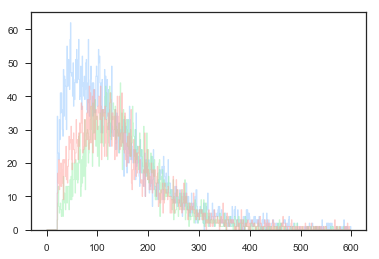

In [13]:
# Do line lengths differ by author?

grouped_df = train_df.groupby('author')
for name, group in grouped_df:
    lengths = [len(line) for line in group['text']]
    plt.hist(lengths, bins=np.arange(600), histtype='step', linewidth=1, alpha=0.5)


In [8]:
# Number of stopwords in the text
eng_stopwords = set(stopwords.words("english"))
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

C:\dev\Miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


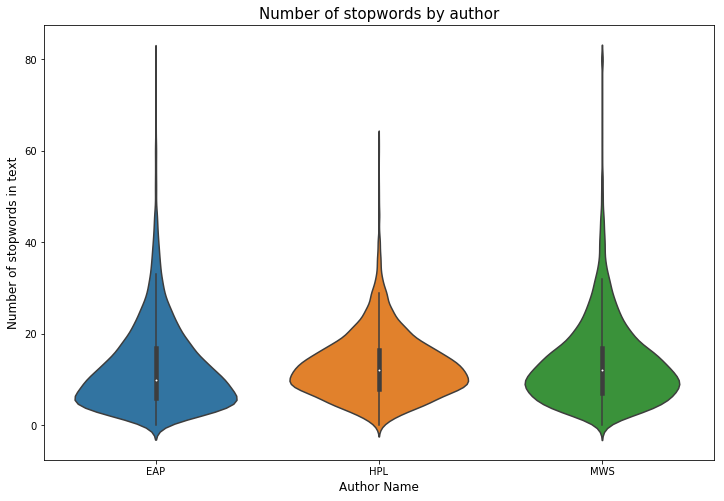

In [10]:
# Do the authors appear to differ in their use of stopwords?
train_df['num_stopwords'].loc[train_df['num_stopwords']>80] = 80 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_stopwords', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of stopwords in text', fontsize=12)
plt.title("Number of stopwords by author", fontsize=15)
plt.show()

In [65]:
from scipy import stats

eap_num_stopwords = train_df.groupby(['author']).get_group('EAP')['num_stopwords'].tolist()
hpl_num_stopwords = train_df.groupby(['author']).get_group('HPL')['num_stopwords'].tolist()
mws_num_stopwords = train_df.groupby(['author']).get_group('MWS')['num_stopwords'].tolist()
F, p = stats.f_oneway(eap_num_stopwords, hpl_num_stopwords, mws_num_stopwords)
print(F)
print(p)

21.638788895
4.09983111576e-10


In [ ]:
def test_pipeline(df, nlp_pipeline, pipeline_name=''):
    y = df['author'].copy()
    X = pd.Series(df['text'])
    rskf = StratifiedKFold(n_splits=5, random_state=1)
    losses = []
    for train_index, test_index in rskf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        nlp_pipeline.fit(X_train, y_train)
        losses.append(metrics.log_loss(y_test, nlp_pipeline.predict_proba(X_test)))
    print(f'{pipeline_name} kfolds log losses: {str([str(round(x, 3)) for x in sorted(losses)])}')
    print(f'{pipeline_name} mean log loss: {round(pd.np.mean(losses), 3)}')

In [ ]:
unigram_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('mnb', MultinomialNB())
])
test_pipeline(train_df, unigram_pipe, "Unigrams only")

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

In [ ]:
print(stopwords)

In [ ]:
first_text_list_cleaned = [word for word in first_text_list if word.lower() not in stopwords]
print(first_text_list_cleaned)
print("="*90)
print("Length of original list: {0} words\n"
      "Length of list after stopwords removal: {1} words"
      .format(len(first_text_list), len(first_text_list_cleaned)))

In [ ]:
stemmer = nltk.stem.PorterStemmer()

In [ ]:
# Defining our sentence
sentence = ["I love to eat Burgers", 
            "I love to eat Fries"]
vectorizer = CountVectorizer(min_df=1)
sentence_transorm = vectorizer.fit_transform(sentence)
vectorizer.get_feature_names()

In [ ]:
text = list(train.text.values)

---

In [ ]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(text)

In [ ]:
lda = LatentDirichletAllocation(n_components=3, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [ ]:
lda.fit(tf)

In [ ]:
n_top_words = 20
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

In [ ]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]

In [ ]:
first_topic.shape

In [ ]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]